**TD;DR**: Using selenium inside a docker container to crawl webistes that need javascript or user interaction + a cluster of those using docker swarm.

While simple HTTP requests are good enough 90% to get the data you want from a website I am always looking for better ways to optimize my crawlers specially in websites that require javascript and user interaction, a login or a click in the right place sometimes give you the access you need. I am looking at to you government websites!

Recently I have seen more solutions to some of these problems in python such as [Splash](https://github.com/scrapinghub/splash) from [ScrapingHub](http://scrapinghub.com/) that is basically a QT browser with an scriptable API. I havent tried it and it definetly looks like a viable option but if I am going to render a webpage I want to do it in a "real" (Chrome) browser.

An easy way to use Chrome (or Firefox or any other popular browser) with an scriptable and multi-language API is using [Selenium](http://www.seleniumhq.org/), which is generally used to test websites, making clicks, fake/real logins and more. To make this process reproducible I used docker to install Selenium, Chrome and the Selenium Chrome driver in a single container, this image can be found at [docker-selenium](https://github.com/danielfrg/docker-selenium) but more and in [docker hub](https://hub.docker.com/r/danielfrg/selenium/) also more (and probably) better selenium images can be found in Docker Hub and the result should be the same.

## Browser

Getting Selenium running its just as easy as having docker and:

```
$ docker pull danielfrg/selenium
$ docker run -it -p 4444:4444 danielfrg/selenium
```

And now you'll have a selenium instance running in port `4444`. If you use `docker-machine` get the docker IP from there and point your brower to that port. In my case `http://192.168.99.101:4444/wd/hub` - this is the same URL you use to point to the Selenium Python API.

Now in Python we can use it for example to crawl the homepage of [yelp.com](http://yelp.com).

Disclaimer: This is just an example. I don't know the terms of service of yelp, if you want to try this in a bigger scale read the TOS.

## Code

Now into the code: Create a Remote Driver, point it to the Selenium URL. Query for `yelp.com` and just for fun get a screenshot.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

In [2]:
driver = webdriver.Remote(command_executor='http://192.168.99.101:4444/wd/hub',
         desired_capabilities=DesiredCapabilities.CHROME)

In [3]:
driver.get("http://www.yelp.com")

In [4]:
image = driver.get_screenshot_as_base64()


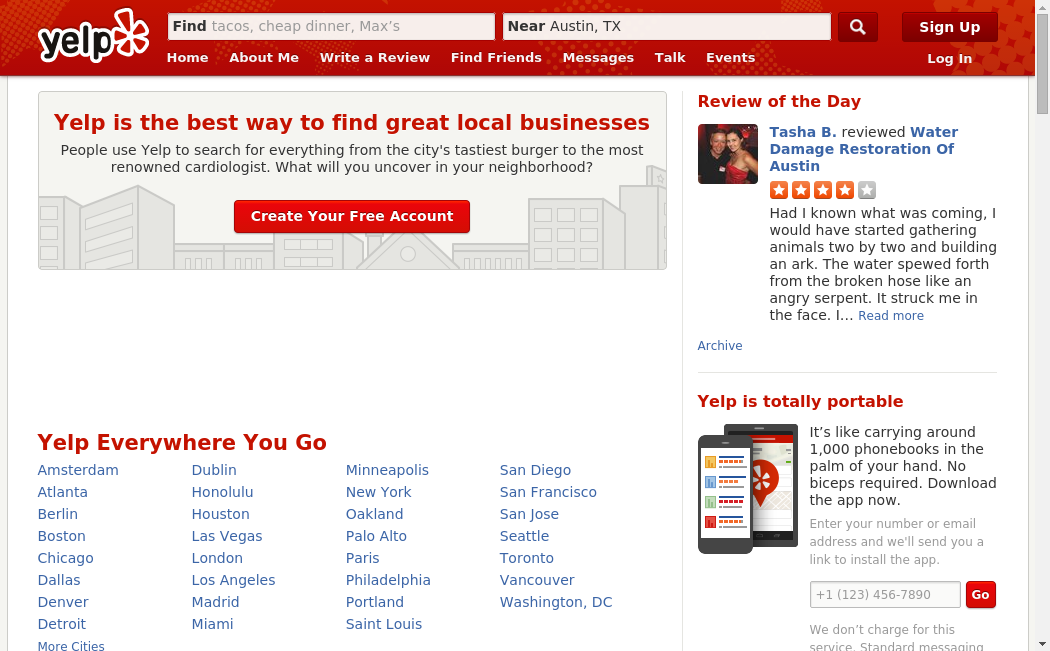

In [5]:
from IPython.display import HTML
HTML("""<img src="data:image/png;base64,{0}">""".format(image))

Here you can see that the render of the website is correct and in my case it pointed me to the Austin website.

Now we can use the Python API to can query for the content that we want from the website. To help me a little bit while looking at HTML source and searching for the css (or xpath) that I need I love the [selector gadget](http://selectorgadget.com/) plugin. For this example I want to get the "Best of Yelp: Austin" section that has some javascript and a scroll button with the different categories. The Selection in this case would be: `#best-of-yelp-module .navigation li`.

In [6]:
best = driver.find_element_by_id('best-of-yelp-module')

In [7]:
navigation = best.find_element_by_class_name('navigation')

In [8]:
sections = navigation.find_elements_by_tag_name('li')

In [9]:
len(sections)

23

So now I know there are 23 links on that section, 21 categories since there are two buttons to scroll.
Now I am going to click on each one of this buttons this is going to change the content of another part of the site: `.main-content` and after that I am getting the name of the category and the list of businesses `.main-content .biz-name`. A little note: I am waiting for 1 second after the `click()` event while the content of the webpage updates, this is to wait for request that might happen and the fade in/out effects.

In [10]:
import time

In [11]:
biz = {}

In [12]:
for section in sections:
    section.click()
    time.sleep(1)
    content = best.find_element_by_class_name('main-content')
    sec_name = content.text.split('\n')[0]
    biz_names = content.find_elements_by_class_name('biz-name')
    biz_names = [name.text for name in biz_names if name.text]
    biz[sec_name] = biz_names

After about 30 seconds I have the content on a dictionary and I can take a look at it.

In [13]:
biz

{u'Active Life': [u'Rocket Electrics',
  u'Barton Creek Greenbelt',
  u'Live Love Paddle',
  u'Eastside Yoga',
  u'Town Lake Metropolitan Parks'],
 u'Arts & Entertainment': [u'Bijou Studio',
  u'Broadway in Austin at Texas Performing Arts',
  u'Skylark Lounge',
  u'Esther\u2019s Follies',
  u'Pinballz Arcade'],
 u'Automotive': [u'Brakes To Go - Mobile Brake Repair',
  u'Terry\u2019s Burnet Road Vehicle Inspections',
  u'Juke Auto',
  u'Auto Glass Solutions',
  u'Above & Beyond Mobile Detailing Services'],
 u'Beauty & Spas': [u'Shaman Modifications Tattoo & Body Piercing',
  u'Mantis Massage',
  u'Beautiful Me',
  u'L7 Salon',
  u'Blush'],
 u'Education': [u'The Stitch Lab',
  u'The University of Texas',
  u'Austin Moto Academy',
  u'The New Movement',
  u'Happy Time Defensive Driving'],
 u'Event Planning & Services': [u'DJ Gatsby & Dapper Sounds',
  u'Korey Howell Photography',
  u'Spike Gillespie',
  u'Kimber Modern',
  u'Tiny Tails To You'],
 u'Financial Services': [u'Kirk Ingels - St

After that we can just stop the driver and stop the docker container.

In [13]:
driver.quit()

## Scale

Ok, that looks pretty cool but how to scale this?

Fortunately with docker now you have a lot of options such as [Kubernetes](http://kubernetes.io/) and [Docker Swarm](https://docs.docker.com/swarm/). In this case I decided to use Docker Swarm since I was lucky to test Rackspace new container service while I was at PyTexas this last weekend.

The process to start the container is exactly the same since docker-swarm serves the same docker API, you just need to point docker client to the docker-swarm cluster. Once thats done I can just execute the same docker commands to create multiple docker containers in the cluster.

```
$ docker pull danielfrg/selenium            # Pull the container in all the nodes
$ docker run -d -p 4444 danielfrg/selenium  # Multiple times to start multiple containers
$ docker run -d -p 4444 danielfrg/selenium 
$ docker run -d -p 4444 danielfrg/selenium
$ docker run -d -p 4444 danielfrg/selenium

$ docker ps
CONTAINER ID        IMAGE                COMMAND                  CREATED             STATUS              PORTS                           NAMES
34867f93db5a        danielfrg/selenium   "sh /opt/selenium/ent"   4 seconds ago       Up 2 seconds        xxx.xx.x.3:49154->4444/tcp   40291b37-aa07-43fd-a7de-1f61673a89a1-n3/sleepy_rosalind
b45d64827e21        danielfrg/selenium   "sh /opt/selenium/ent"   6 seconds ago       Up 4 seconds        xxx.xx.x.2:49154->4444/tcp    40291b37-aa07-43fd-a7de-1f61673a89a1-n2/focused_brown
8a9da9801ee3        danielfrg/selenium   "sh /opt/selenium/ent"   8 seconds ago       Up 7 seconds        xxx.xx.x.1:49154->4444/tcp    40291b37-aa07-43fd-a7de-1f61673a89a1-n1/kickass_euclid
59de7a4811ae        danielfrg/selenium   "sh /opt/selenium/ent"   13 seconds ago      Up 11 seconds       xxx.xx.x.3:49153->4444/tcp   40291b37-aa07-43fd-a7de-1f61673a89a1-n3/elegant_sammet
11b13963a2e0        danielfrg/selenium   "sh /opt/selenium/ent"   15 seconds ago      Up 13 seconds       xxx.xx.x.2:49153->4444/tcp    40291b37-aa07-43fd-a7de-1f61673a89a1-n2/dreamy_curie
7beecb6a9e8a        danielfrg/selenium   "sh /opt/selenium/ent"   16 seconds ago      Up 15 seconds       xxx.xxx.x.1:49153->4444/tcp    40291b37-aa07-43fd-a7de-1f61673a89a1-n1/lonely_bell

```

Now that the containers are running we can use the [Python docker API](https://github.com/docker/docker-py) to get the IP and port of the containers.

In [1]:
import os
from docker import Client
from docker.utils import kwargs_from_env

In [2]:
kwargs = kwargs_from_env()
kwargs['tls'].assert_hostname = False
client = Client(**kwargs)

In [3]:
containers = client.containers()

In [4]:
seleniums = [c for c in containers if c['Image'] == 'danielfrg/selenium']

In [5]:
urls = [s['Ports'][0]['IP'] + ':' + str(s['Ports'][0]['PublicPort']) for s in seleniums]

In [6]:
urls

[u'104.130.0.130:49154',
 u'104.130.0.83:49154',
 u'104.130.0.80:49154',
 u'104.130.0.130:49153',
 u'104.130.0.83:49153',
 u'104.130.0.80:49153']

Now with this we have a pool of seleniums running that we can use to crawl not only one single page but a larger number of pages.

## Final thoughts

This was a simple experiment for a more complete crawler that is based on newer technologies and that can target a larger number of websites. As I mention earlier data in the goverment website is very helpful in a lot of cases but is usually in some old system that requires clicks, search forms and stuff like that, this technique can be useful in those cases.

For a complete system maybe a better integration with Scrapy is needed and there are some experiements between scrapy + selenium:

- http://stackoverflow.com/questions/17975471/selenium-with-scrapy-for-dynamic-page
- https://github.com/voliveirajr/seleniumcrawler